In [1]:
import sys

sys.path.append('/home/daniel/ml_workspace/circuit-finder')

In [2]:
from circuit_finder.pretrained import load_model 

model = load_model()

W_U = model.W_U

/home/daniel/ml_workspace/circuit-finder/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


In [3]:
import torch 
U, S, V = torch.svd(W_U)

<Axes: >

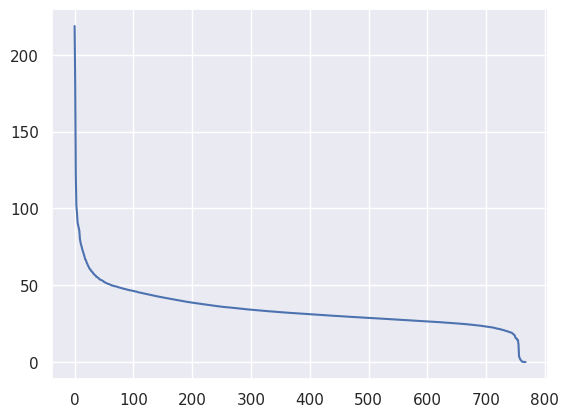

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

x = torch.arange(len(S))
y = S

sns.lineplot(x = x.detach().cpu().numpy(),  y= y.detach().cpu().numpy())

In [8]:
print(S[-12:])

tensor([3.5508e+00, 2.7303e+00, 1.7166e+00, 1.2076e+00, 7.8159e-01, 3.1981e-01,
        1.2803e-01, 7.1358e-02, 2.8413e-02, 1.9101e-02, 1.3441e-02, 1.4067e-05],
       device='cuda:0', grad_fn=<SliceBackward0>)


In [11]:
print(U.shape)

torch.Size([768, 768])


In [12]:
U_null = U[:, -12:]

In [13]:
# Computed in other notebook
maybe_entropy_features = [3153, 20483, 2270, 23503, 19921, 21617, 21617, 9147, 21818, 13918, 6567, 7642, 20460, 12053, 2347, 18831, 4603, 19871, 12410, 1303, 11216, 21642]

In [14]:
# Load the layer 11 mlp transcoder
from circuit_finder.pretrained import load_hooked_mlp_transcoders
transcoder = load_hooked_mlp_transcoders([11])[11]



Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

In [15]:
# Get decoder weights
W_dec = transcoder.W_dec
print(W_dec.shape)

torch.Size([24576, 768])


In [16]:
W_dec_selected = W_dec[maybe_entropy_features, :]


In [19]:
# Compute projection of W_dec selected into U_null
proj = torch.matmul(W_dec_selected, U_null)
print(proj.shape)

proj.norm(dim=-1)

torch.Size([22, 12])


tensor([0.5109, 0.9608, 0.4922, 0.2112, 0.4805, 0.4410, 0.4410, 0.9613, 0.9614,
        0.3729, 0.9610, 0.9610, 0.3543, 0.2348, 0.9615, 0.9619, 0.1646, 0.9630,
        0.9636, 0.9653, 0.9635, 0.9612], device='cuda:0',
       grad_fn=<LinalgVectorNormBackward0>)

Text(0.5, 1.0, 'Trans-MLP-11 decoder component in nullspace of W_U')

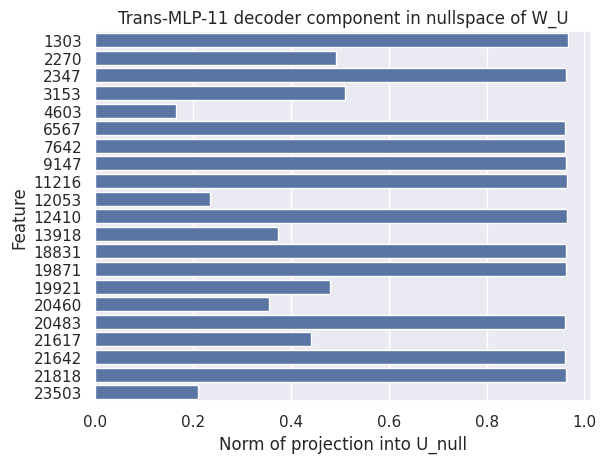

In [29]:
import matplotlib.pyplot as plt

sns.barplot(
    y = maybe_entropy_features, 
    x = proj.norm(dim=-1).detach().cpu().numpy(),
    orient = 'y'
)
plt.ylabel("Feature")
plt.xlabel("Norm of projection into U_null")
plt.title("Trans-MLP-11 decoder component in nullspace of W_U")

In [30]:
W_enc_selected = transcoder.W_enc[:, maybe_entropy_features]

(22, 22)


Text(0.5, 1.0, 'Pairwise W_enc cosine similarity')

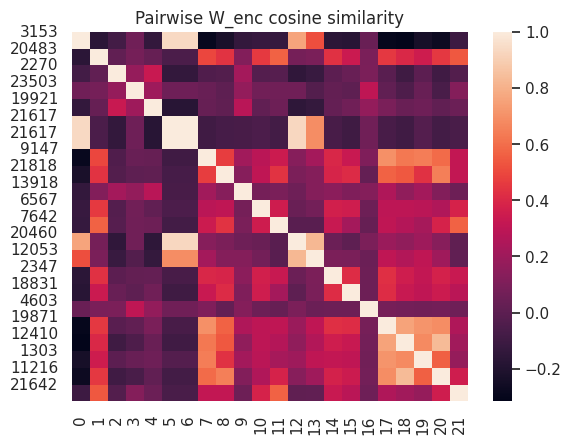

In [45]:
# Plot pairwise cosine similarities of the selected features
from sklearn.metrics.pairwise import cosine_similarity

enc_cos_sim = cosine_similarity(W_enc_selected.T.detach().cpu().numpy())
print(enc_cos_sim.shape)
sns.heatmap(enc_cos_sim)
n_entropy_features = len(maybe_entropy_features)
plt.yticks(
    ticks = range(n_entropy_features), 
    labels = maybe_entropy_features
)
plt.title("Pairwise W_enc cosine similarity")

Text(0.5, 1.0, 'Pairwise W_dec cosine similarity')

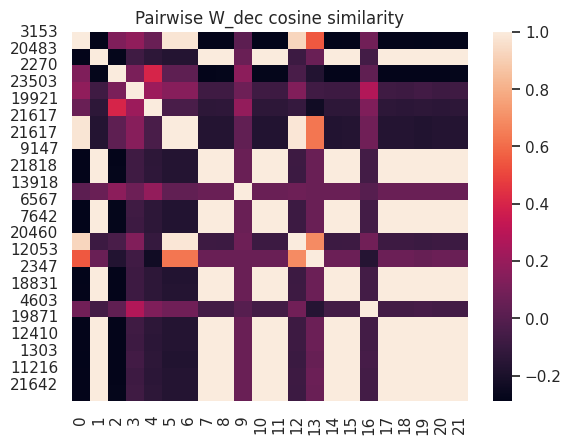

In [50]:
dec_cos_sim = cosine_similarity(W_dec_selected.detach().cpu().numpy())

sns.heatmap(dec_cos_sim)
plt.yticks(
    ticks = range(n_entropy_features), 
    labels = maybe_entropy_features
)
plt.title("Pairwise W_dec cosine similarity")

# Find all entropy neurons

In [52]:
entropy_neurons = [584, 1611, 2123,  2378, 2870, 2910]

In [53]:
mlp_11 = model.blocks[11].mlp
W_out_selected = mlp_11.W_out[entropy_neurons, :]
print(W_out_selected.shape)

torch.Size([6, 768])


In [72]:
# Project into U_null
proj_out = torch.matmul(W_out_selected, U_null)
W_out_norm = W_out_selected.norm(dim=-1)
print(proj_out.norm(dim=-1) / W_out_norm)
proj_out_frac = proj_out.norm(dim=-1) / W_out_norm

tensor([0.9900, 0.9614, 0.9772, 0.9394, 0.9733, 0.9548], device='cuda:0',
       grad_fn=<DivBackward0>)


Text(0, 0.5, 'Neuron')

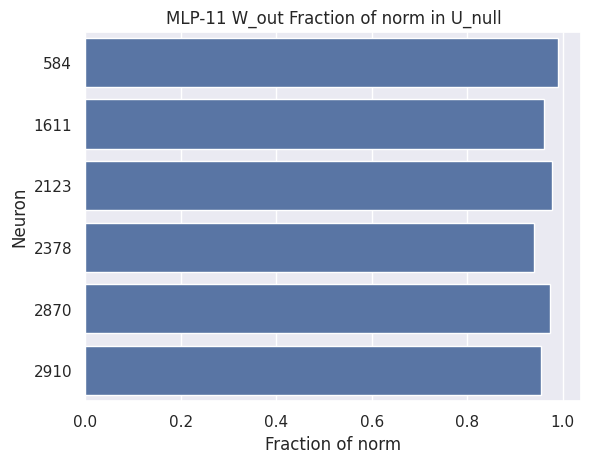

In [74]:
# barplot
sns.barplot(
    y = entropy_neurons, 
    x = proj_out_frac.detach().cpu().numpy(),
    orient = 'y'
)
plt.title("MLP-11 W_out Fraction of norm in U_null")
plt.xlabel("Fraction of norm")
plt.ylabel("Neuron")

Text(0.5, 1.0, 'MLP-11 W_out pairwise cosine similarity')

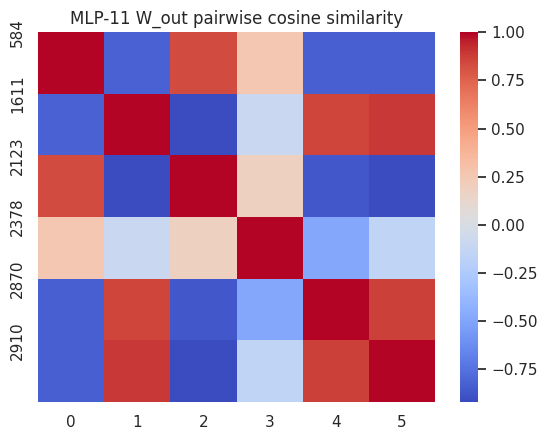

In [60]:
W_out_cos_sim = cosine_similarity(W_out_selected.detach().cpu().numpy())

n_entropy_neurons = len(entropy_neurons)
# coolwarm
sns.heatmap(W_out_cos_sim, cmap='coolwarm')
plt.yticks(
    ticks = range(n_entropy_neurons), 
    labels = entropy_neurons
)
plt.title("MLP-11 W_out pairwise cosine similarity")

In [61]:
# Cluster the entropy neurons by decoder weight. 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(W_out_selected.detach().cpu().numpy())
print(kmeans.labels_)

[2 1 2 0 1 1]


[3, 1, 4, 5, 0, 2]


Text(0.5, 1.0, 'MLP-11 W_out pairwise cosine similarity, clustered')

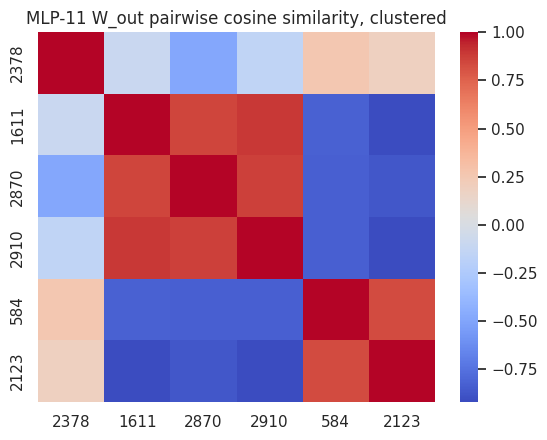

In [67]:
# Heatmap, but reorder by cluster
import numpy as np

reorder = []
for i in range(3):
    for j in range(n_entropy_neurons):
        if kmeans.labels_[j] == i:
            reorder.append(j)

print(reorder)

sns.heatmap(W_out_cos_sim[reorder, :][:, reorder], cmap='coolwarm')
plt.yticks(
    ticks = np.arange(n_entropy_neurons) + 0.5, 
    labels = [entropy_neurons[i] for i in reorder]
)
plt.xticks(
    ticks = np.arange(n_entropy_neurons) + 0.5, 
    labels = [entropy_neurons[i] for i in reorder]

)
plt.title("MLP-11 W_out pairwise cosine similarity, clustered")


In [69]:
kmeans.cluster_centers_.shape

(3, 768)

Text(0.5, 1.0, 'Cosine similarity of W_dec_selected with cluster centroids')

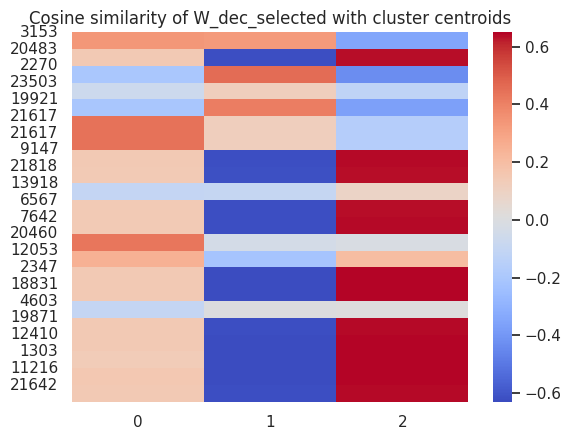

In [79]:
centroids = kmeans.cluster_centers_

# Compute cosine sim with all W_dec_selected
cos_sims = cosine_similarity(
    W_dec_selected.detach().cpu().numpy(), 
    centroids
)

sns.heatmap(cos_sims, cmap='coolwarm')
plt.yticks(
    ticks = range(n_entropy_features), 
    labels = maybe_entropy_features
)
plt.title("Cosine similarity of W_dec_selected with cluster centroids")


In [81]:
centroids = kmeans.cluster_centers_

# Compute cosine sim with all W_dec_selected
cos_sims = cosine_similarity(
    W_dec.detach().cpu().numpy(), 
    centroids
)

cos_sims.shape

(24576, 3)

In [95]:
significant_idx = cos_sims.max(axis=-1) > 0.9
# Select the significant features
print(significant_idx.shape)
print(significant_idx.sum())

(24576,)
147


In [96]:
W_dec_significant = W_dec[significant_idx, :]
significant_features = [i for i in range(W_dec.shape[0]) if significant_idx[i]]
significant_cos_sims = cos_sims[significant_idx, :]

Text(0.5, 1.0, 'MLP features with > 0.9 cos sim to one of the known entrop neurons')

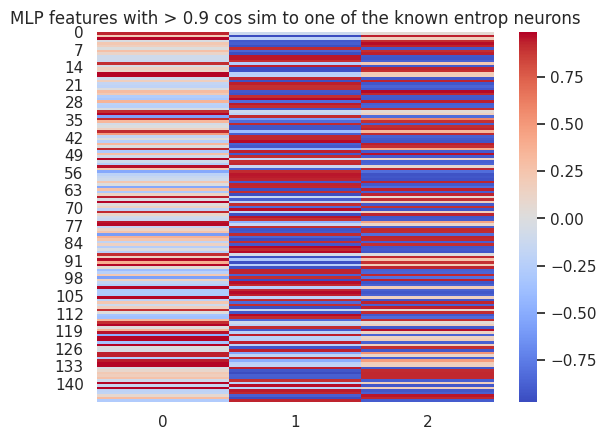

In [98]:
sns.heatmap(significant_cos_sims, cmap='coolwarm')
plt.title("MLP features with > 0.9 cos sim to one of the known entrop neurons")